<a href="https://colab.research.google.com/github/JackSagliano/water-level-prediction/blob/main/Water_level_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vento U e Vento V (Vettori del vento)
- Vento U (Zonale): Rappresenta il movimento lungo l'asse Est-Ovest.
  - Valore positivo: il vento soffia verso Est.
  - Valore negativo: il vento soffia verso Ovest.
- Vento V (Meridionale): Rappresenta il movimento lungo l'asse Nord-Sud.
  - Valore positivo: il vento soffia verso Nord.
  - Valore negativo: il vento soffia verso Sud.

Il vento che crea più problemi a Venezia è lo Scirocco, che soffia da Sud-Est verso Nord-Ovest. Nel tuo dataset, lo Scirocco apparirà come una combinazione di V negativo (molto forte) e U negativo.

----------------------------------------------------------------------


Le Effemeridi (Marea Astronomica)
  - Le effemeridi descrivono la posizione relativa della Terra, della Luna e del Sole. Sono dati puramente astronomici e prevedibili al 100% per i prossimi secoli. Le effemeridi, in questo notebook, sono descritte da 6 variabili normalizzate e descrivono i cicli che causano la marea deterministica:
    - Ciclo Semidiurno e Diurno: L'innalzamento e abbassamento regolare dovuto all'attrazione gravitazionale della Luna e del Sole.
    - Ciclo Mensile: Le fasi lunari (luna piena/nuova portano maree più alte).

  Perché servono alla rete? Il livello dell'acqua che devi prevedere è la somma di:
  $$\text{Livello Totale} = \text{Marea Astronomica (Effemeridi)} + \text{Storm Surge (Vento + Pressione)}$$

  Senza le effemeridi, la tua rete non saprebbe mai se l'acqua è alta perché c'è tempesta o semplicemente perché è il momento dell'alta marea lunare.

# Water level prediction using ERA5

## Problem description
Given a set of  5,000  nodes over the Northern Adriatic Sea, defined by varying longitude and latitude (visualized as red spots in image below), you are supposed to infer the water level of these points at each hour in a given range, using a neural network.

In [ ]:
#import base64
#from IPython.display import HTML, display

#with open("graphical_visualization.png", "rb") as f:
#    encoded = base64.b64encode(f.read()).decode("utf-8")
#
#display(HTML(f"""<img src="data:image/png;base64,{encoded}" width="800"/>"""))

The information you can use to predict these values are:
* **latitude** and **longitude** of the nodes
* the **ephemerides** relative to the sun and the moon at each hour (we consider a single value of the ephemeridies for the whole region). Ephemerides are key predictors of tidal motion and are therefore important for the prediction of water level. The provided values of the ephemerides are already normalized.
* **weather variables** (wind components and pressure) derived from ERA5 dataset (not normalized). Due to the low resolution of ERA5, these values are organized as an array of shape $5 \times 9$ for each hour and each variable. A supporting function is provided to convert a given (latitude, longitude) of a node to the associated index of ERA5 array. Weather variables are important to predict phenomenon such as storm surge: another key component of water level.

For the prediction of the water level at timestamp $t$, you are allowed to use a sequence of any length of the input variables relative to past timesteps, but no future information. The output variable (corresponding to the **water level**) **CANNOT** be used as input to the model, not even for past timestamps.   


# Data Download

In [1]:
import gdown

train data

In [2]:
!gdown 1Ncexf_vB55cpiCeNr-hIRrdpquYaav6B

Downloading...
From (original): https://drive.google.com/uc?id=1Ncexf_vB55cpiCeNr-hIRrdpquYaav6B
From (redirected): https://drive.google.com/uc?id=1Ncexf_vB55cpiCeNr-hIRrdpquYaav6B&confirm=t&uuid=7c7660ed-850d-48c5-9fa6-88fd8f35d05f
To: /content/wl_2010-2020.npy
100% 1.75G/1.75G [00:24<00:00, 71.9MB/s]


In [3]:
!gdown 1THbGvO9mVjg_wfZTabRbQBOVpaECl3my

Downloading...
From: https://drive.google.com/uc?id=1THbGvO9mVjg_wfZTabRbQBOVpaECl3my
To: /content/dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy
100% 4.21M/4.21M [00:00<00:00, 30.9MB/s]


In [4]:
!gdown 16M1zB54PKkKS6SK8W_U83UURWu1T_AxR

Downloading...
From: https://drive.google.com/uc?id=16M1zB54PKkKS6SK8W_U83UURWu1T_AxR
To: /content/ERA5_adriatic_u10v10sp_2010-2019.npy
100% 94.7M/94.7M [00:01<00:00, 62.2MB/s]


In [5]:
!gdown 161OYs8KQSn3RrXezCNwFvOewXLJe5wBf

Downloading...
From: https://drive.google.com/uc?id=161OYs8KQSn3RrXezCNwFvOewXLJe5wBf
To: /content/tvec_2010-2019.npy
100% 4.21M/4.21M [00:00<00:00, 30.6MB/s]


test data

In [6]:
!gdown 1iwqd4xzHc98OYqBpGsuUW4SG5AQDtdNR #(8784, 5000)  hours,nodes water levels

Downloading...
From (original): https://drive.google.com/uc?id=1iwqd4xzHc98OYqBpGsuUW4SG5AQDtdNR
From (redirected): https://drive.google.com/uc?id=1iwqd4xzHc98OYqBpGsuUW4SG5AQDtdNR&confirm=t&uuid=daf94c47-fac9-43a0-b94c-774684e0836e
To: /content/wl_2020.npy
100% 176M/176M [00:02<00:00, 61.6MB/s]


In [7]:
!gdown 1cHqyeXtmaiC_3v9uadMD7Y0hONGf2R1q

Downloading...
From: https://drive.google.com/uc?id=1cHqyeXtmaiC_3v9uadMD7Y0hONGf2R1q
To: /content/dist_alt_az_moon-sun_coord13-45_2020_norm.npy
100% 422k/422k [00:00<00:00, 6.25MB/s]


In [8]:
!gdown 1AoFAD2viMarikhU5b5Etdsklx08EzKKb

Downloading...
From: https://drive.google.com/uc?id=1AoFAD2viMarikhU5b5Etdsklx08EzKKb
To: /content/ERA5_adriatic_u10v10sp_2020.npy
100% 4.74M/4.74M [00:00<00:00, 22.7MB/s]


In [9]:
!gdown 1sWoTlJih-mqDdP9TBzhyXTqHHS5Jr9fe

Downloading...
From: https://drive.google.com/uc?id=1sWoTlJih-mqDdP9TBzhyXTqHHS5Jr9fe
To: /content/tvec_2020.npy
100% 422k/422k [00:00<00:00, 5.58MB/s]


latitude and longitude of nodes

In [10]:
!gdown 1Mg52QAIo4bfpzJF0dsI8mpZf09tHTzj8
!gdown 1wWz0EWbGiBkZ0vfJD8KeZkmVZfmRiYLk

Downloading...
From: https://drive.google.com/uc?id=1Mg52QAIo4bfpzJF0dsI8mpZf09tHTzj8
To: /content/lon.npy
100% 20.1k/20.1k [00:00<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wWz0EWbGiBkZ0vfJD8KeZkmVZfmRiYLk
To: /content/lat.npy
100% 20.1k/20.1k [00:00<00:00, 61.8MB/s]


## File description

Spatial coordinates

`lat.npy`
- latitudes of the 5000 target nodes,
- shape (5000,)

`lon.npy` :
- longitudes of the 5000 target nodes
- shape (5000,)

## Training data

hourly values from 01/01/2010 until 31/12/2019 (87648 hours)

`wl_2010-2019.npy`
- Water level measurements.
- Shape: (87648, 5000)

`dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy`
- Ephemerides features
- Shape: (6, 87648)

`ERA5_adriatic_u10v10sp_2010-2019.npy`
- ERA5 predictors (variables, timestamps, x , y)
- Shape: (3, 87648, 5, 9)

`tvec_2010-2019.npy`
- Explicit time information
- Shape: (87648)

## Test data

hourly values from 01/01/2020 until 31/12/2020 (8784 hours)

`wl_2020.npy`
- Water level measurements, Shape: (8784, 5000)

`dist_alt_az_moon-sun_coord13-45_2020_norm.npy`
- Ephemerides features
- Shape: (6, 8784)

`ERA5_adriatic_u10v10sp_2020.npy`
- ERA5 predictors (variables, timestamps, x , y)
- Shape: (3, 8784, 5, 9)

`tvec_2020.npy`
- Explicit time information
- Shape: (87648)

## We use cartopy for visualizations

In [11]:
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 129.3 MB/s eta 0:00:00


In [12]:
import numpy as np
from tqdm import tqdm
from datetime import datetime

import matplotlib.pyplot as plt

In [13]:
# load nodes coordinates
lat_vec = np.load("./lat.npy") # (5000, )
lon_vec = np.load("./lon.npy") # (5000, )

#load train data
train_wl = np.load("./wl_2010-2020.npy") # (87648, 5000)
train_ephem = np.load("./dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy") # (6, 87648)
train_era5 = np.load("./ERA5_adriatic_u10v10sp_2010-2019.npy") # (3, 87648, 5, 9)
train_tvec = np.load("./tvec_2010-2019.npy") # (6, 87648))

#load test data
test_wl = np.load("./wl_2020.npy") # (8784, 5000)
test_ephem = np.load("./dist_alt_az_moon-sun_coord13-45_2020_norm.npy") # (6, 8784)
test_era5 = np.load("./ERA5_adriatic_u10v10sp_2020.npy")#(3, 8784, 5, 9)
test_tvec = np.load("./tvec_2020.npy") # (6,8784)

## Data description

**ERA5:**
- Gridded, hourly atmospheric data
- Spatial resolution: $5 \times 9$ grid over the study area
- 3 variables: u10, v10 (10m wind components), surface pressure
- explicit time: Year,Month,Day,Hour,Minute,Second

**EPHEMERIDES:**
- 6 scalar features describing Moon–Sun geometry
  (e.g. distance, altitude, azimuth)
- Hourly resolution
- Spatially constant (same values for all target nodes)

**TARGET:**
- Water level at 5000 spatial nodes in the Northern Adriatic
- Each node has fixed latitude and longitude
- A function is provided to match node coordinates to the closest era5 data



In [14]:
# utilities functions
def get_era5_coord(lat, lon):
    """
    Function to get era5 data from data coordinates
    """
    era5_row, era5_col = 5, 9
    lat_min, lat_max = 44.94972, 45.8
    lon_min, lon_max = 12.12863, 13.81283

    delta_lat = lat_max - lat_min
    delta_lon = lon_max - lon_min

    lon_coord = np.ceil((lon - lon_min) / delta_lon * (era5_col -1))
    lat_coord = 4 - np.ceil((lat - lat_min) / delta_lat * (era5_row - 1))

    return int(lat_coord), int(lon_coord)

def RMSE(wl_true, wl_pred):
    """
    Root mean squared error
    """
    return np.sqrt(np.mean(np.square(wl_pred - wl_true)))

In [15]:
#example of usage of get_era5_coord
node_number = np.random.randint(np.shape(test_wl)[1])
era5_coords = get_era5_coord(lat_vec[node_number], lon_vec[node_number])
print(f"ERA5 grid coords for node {node_number}: {era5_coords}")
hour = np.random.randint(np.shape(test_wl)[1])
print(test_tvec[:,hour])
hour_time = datetime(*test_tvec[:,hour].astype(int))
print(hour_time)
wind0,wind1,pression = test_era5[:,hour,era5_coords[0],era5_coords[1]]
print(f"node {node_number} at time {hour_time} (no {hour}): wind0 = {wind0:.3f}, wind1 = {wind1:1.3f}, pression ={pression:.3f}")

ERA5 grid coords for node 3638: (1, 7)
[2020.    7.    5.   21.    0.    0.]
2020-07-05 21:00:00
node 3638 at time 2020-07-05 21:00:00 (no 4485): wind0 = -0.783, wind1 = -1.609, pression =97944.625


As you may observe, wind and especially pressure **are not normalized!!**

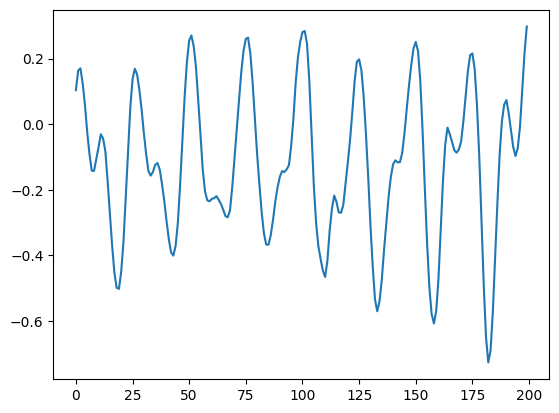

In [ ]:
# Visualize a single node variability,
plt.plot(test_wl[:200, 0])

In the picture above you may easily recognize the tydal cycle, with a period of approximately 24 hours.

/usr/local/lib/python3.12/dist-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  result = super().scatter(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


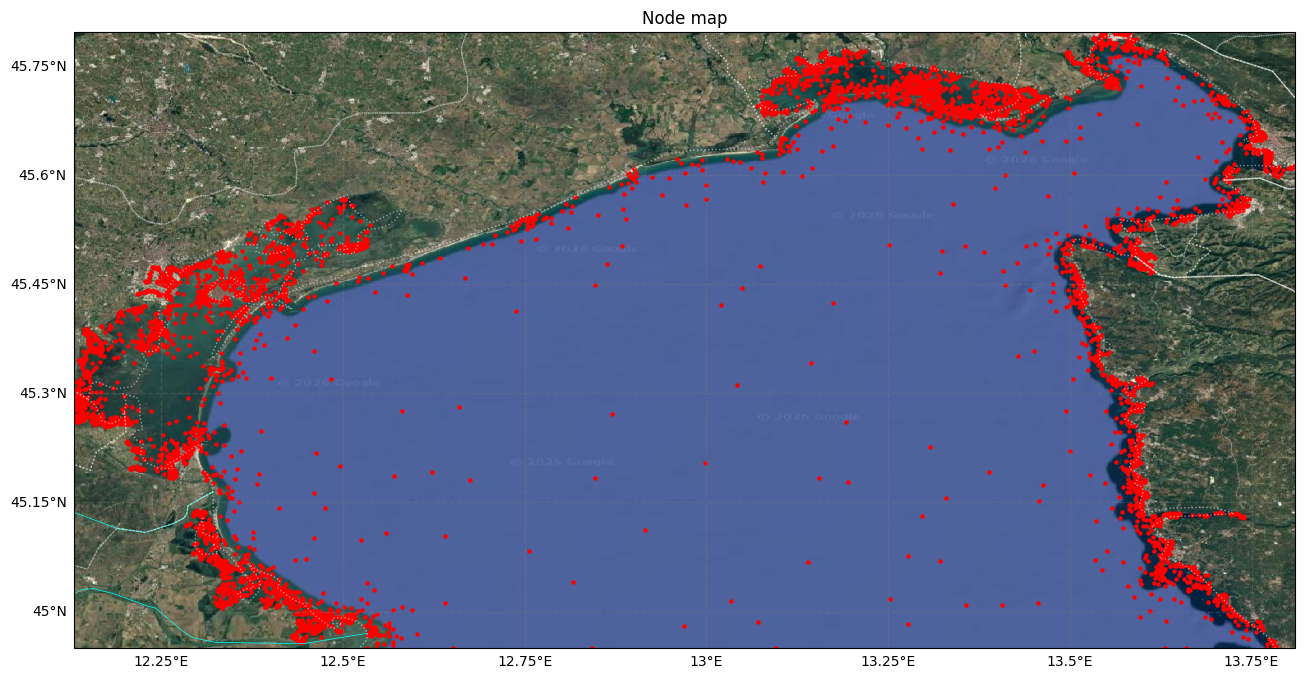

In [16]:
# Create figure and map
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
(lat_min, lat_max), (lon_min, lon_max) = (lat_vec.min(), lat_vec.max()), (lon_vec.min(), lon_vec.max())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

stamen_terrain = cimgt.GoogleTiles(style='satellite')
ax.add_image(stamen_terrain, 10)

ax.add_feature(cfeature.RIVERS, edgecolor='cyan', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='white', alpha=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='white', alpha=0.5)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = gl.right_labels = False

# Plot red dots
# Note: Ensure data is visible against the varied satellite background
sc = ax.scatter(lon_vec, lat_vec, cmap="viridis", c="r", s=5, marker='o', transform=ccrs.PlateCarree(), vmin=0.07, vmax=0.15)
# Increased 's' (size) slightly to make dots visible against satellite texture

plt.title(f'Node map')
plt.savefig("graphical_visualization.png", dpi=400)
plt.show()

# What to deliver

The problem consists in inferring the water level for all nodes in the test set (year 2020).

The solution must be evaluated using RMSE with respect to the given test values.





As an indicative baseline, you may consider persistence, namely using the water level of the previous timestep to predict the current value:

In [17]:
print(f"persistence baseline: {RMSE(test_wl[:-1],test_wl[1:]):.4f}")

persistence baseline: 0.0859


Any marginal improvement w.r.t. the baseline is significant.

As usual, you are supposed to upload a single notebook with your solution, evidence of training, and the final RMSE.

Please note that the model **cannot use** sea levels of previous times steps.

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def crea_modello_acqua(input_shape):
    # L'ingresso è una lista di 5032 punti, ognuno con 3 valori (vento_u, vento_v, pressione)
    inputs = Input(shape=input_shape)

    # PASSO 1: Analisi Locale
    # La rete guarda ogni punto geografico da solo.
    # Conv1D con kernel_size=1 significa: "Analizza punto per punto senza mischiarli ancora"
    x = layers.Conv1D(64, kernel_size=1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x) # Questo aiuta a imparare più in fretta

    x = layers.Conv1D(128, kernel_size=1, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # PASSO 2: Visione Globale
    # Ora la rete deve riassumere tutto. Fa una media di cosa succede in tutto il mare.
    # Trasforma i 5032 punti in un unico vettore di riassunto.
    global_features = layers.GlobalAveragePooling1D()(x)

    x = layers.Dropout(0.3)(global_features) # Spegne qualche neurone a caso per non imparare a memoria

    # PASSO 3: Predizione Finale
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='linear')(x) # Un solo numero in uscita: il livello dell'acqua

    model = models.Model(inputs, outputs)
    return model

# Costruiamo il modello virtualmente
# 5032 sono i nodi, 3 sono le caratteristiche (u, v, pressione)
model = crea_modello_acqua((5032, 3))
model.summary() # Ti mostrerà una tabella riassuntiva

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5032, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5032, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5032, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5032, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5032, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [19]:
# Compilazione
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks: sono dei "guardiani".
# Se il modello smette di migliorare, riducono la velocità di apprendimento o salvano il migliore.
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [20]:
print("Inizio l'addestramento... portati pazienza!")

history = model.fit(
    x_train, y_train,          # I dati di studio
    validation_data=(x_test, y_test), # I dati per la verifica (se li hai chiamati così nel notebook)
    epochs=50,                 # Quante volte ripassa il libro
    batch_size=32,             # Quanti esempi guarda alla volta
    callbacks=callbacks
)

Inizio l'addestramento... portati pazienza!


NameError: name 'x_train' is not defined